In [1]:
import mne
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
schizophrenic_epochs = mne.read_epochs('../processed_schizophrenic_eeg-epo.fif')

Reading d:\research-reservoir\Schizo-hormone\Test\..\processed_schizophrenic_eeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1996.00 ms
        0 CTF compensation matrices available
Not setting metadata
15819 matching events found
No baseline correction applied
0 projection items activated


In [3]:
def extract_psd_features(epochs):
    psd_features = []
    for epoch in epochs.get_data():
        psd, freqs = mne.time_frequency.psd_array_multitaper(
            epoch, sfreq=epochs.info['sfreq'], fmin=0.5, fmax=40, verbose=False)
        psd_mean = psd.mean(axis=1)
        psd_features.append(psd_mean)
    return np.array(psd_features)

In [4]:
X_schizophrenic = extract_psd_features(schizophrenic_epochs)

scaler = StandardScaler()
X_schizophrenic_scaled = scaler.fit_transform(X_schizophrenic)

C:\Users\anisr\AppData\Local\Temp\ipykernel_9196\730980185.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


In [5]:
time_steps = 10 
generator = TimeseriesGenerator(
    X_schizophrenic_scaled, X_schizophrenic_scaled, length=time_steps, batch_size=32)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(
    time_steps, X_schizophrenic_scaled.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(X_schizophrenic_scaled.shape[1]))

model.compile(optimizer='adam', loss='mse')

model.fit(generator, epochs=20, verbose=1)

Epoch 1/20
495/495 [==============================] - 4s 4ms/step - loss: 1.1675
Epoch 2/20
495/495 [==============================] - 2s 4ms/step - loss: 1.0309
Epoch 3/20
495/495 [==============================] - 2s 4ms/step - loss: 0.9991
Epoch 4/20
495/495 [==============================] - 2s 4ms/step - loss: 1.0081
Epoch 5/20
495/495 [==============================] - 2s 4ms/step - loss: 0.9211
Epoch 6/20
495/495 [==============================] - 2s 4ms/step - loss: 1.1784
Epoch 7/20
495/495 [==============================] - 2s 4ms/step - loss: 0.8484
Epoch 8/20
495/495 [==============================] - 2s 4ms/step - loss: 0.8618
Epoch 9/20
495/495 [==============================] - 2s 4ms/step - loss: 0.5927
Epoch 10/20
495/495 [==============================] - 2s 4ms/step - loss: 0.6546
Epoch 11/20
495/495 [==============================] - 2s 4ms/step - loss: 0.5190
Epoch 12/20
495/495 [==============================] - 2s 4ms/step - loss: 0.6477
Epoch 13/20
495/495 [====

In [7]:
predicted = model.predict(generator)

495/495 [==============================] - 2s 4ms/step


In [8]:
predicted_psd = []
for pred in predicted:
    psd, freqs = mne.time_frequency.psd_array_multitaper(
        pred, sfreq=schizophrenic_epochs.info['sfreq'], fmin=0.5, fmax=40, verbose=False)
    psd_mean = psd.mean()  
    predicted_psd.append(psd_mean)
predicted_psd = np.array(predicted_psd)
actual_psd = extract_psd_features(schizophrenic_epochs)

C:\Users\anisr\AppData\Local\Temp\ipykernel_9196\730980185.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epochs.get_data():


In [9]:
import matplotlib.pyplot as plt


def plot_psd_comparison(freqs, actual_psd, predicted_psd, title='PSD Comparison'):
    actual_psd_mean = actual_psd.mean(axis=0)  
    predicted_psd_mean = predicted_psd.mean(axis=0)

    if actual_psd_mean.ndim > 1:
        actual_psd_mean = actual_psd_mean.mean(axis=0)
    if predicted_psd_mean.ndim > 1:
        predicted_psd_mean = predicted_psd_mean.mean(axis=0)

    print("Frequency dimension:", freqs.shape)
    print("Actual PSD mean shape:", actual_psd_mean.shape)
    print("Predicted PSD mean shape:", predicted_psd_mean.shape)

    plt.figure(figsize=(12, 6))
    plt.plot(freqs, actual_psd_mean, label='Actual PSD', color='blue')
    plt.plot(freqs, predicted_psd_mean, label='Predicted PSD',
             color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.legend()
    plt.show()

Frequency dimension: (3,)
Actual PSD mean shape: (3,)
Predicted PSD mean shape: (3,)


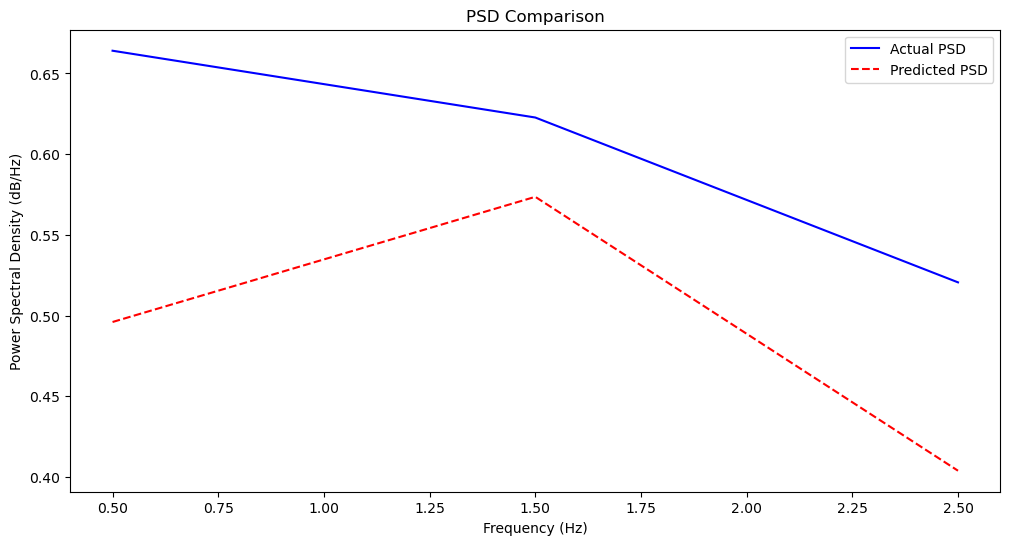

In [10]:
freqs = np.array([0.5, 1.5, 2.5]) 
actual_psd = np.random.rand(10, 3)  
predicted_psd = np.random.rand(10, 3)  

plot_psd_comparison(freqs, actual_psd, predicted_psd)